In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN

# -------------------------------
# Step 1: Load top-100 selected features
# -------------------------------
feature_path = "../output/f_score_with_p_value.csv"
feature_df = pd.read_csv(feature_path)

if 'feature' in feature_df.columns:
    selected_features = feature_df['feature'].values[:100]
else:
    selected_features = feature_df.iloc[:100, 0].values

print(f"[INFO] Loaded top-{len(selected_features)} selected features.")

# -------------------------------
# Step 2: Load data
# -------------------------------
X_full = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y_full = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()
X = X_full[:, selected_features]

# -------------------------------
# Step 3: Standardize
# -------------------------------
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# -------------------------------
# Step 4: Cross-validation setup
# -------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

sampling_strategies = {
    "NoResample": None,
    "SMOTE": SMOTE(random_state=42, k_neighbors=1),
    "ADASYN": ADASYN(random_state=42, n_neighbors=1),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42, k_neighbors=1),
    "SMOTEENN": SMOTEENN(random_state=42, smote=SMOTE(k_neighbors=1))
}

# -------------------------------
# Step 5: Loop over strategies
# -------------------------------
results = defaultdict(lambda: {"macro_f1": [], "weighted_f1": [], "reports": [], "matrices": []})

for strat_name, sampler in sampling_strategies.items():
    print(f"[INFO] Evaluating strategy: {strat_name}")

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_std, y_full)):
        X_train, X_val = X_std[train_idx], X_std[val_idx]
        y_train, y_val = y_full[train_idx], y_full[val_idx]

        if sampler is not None:
            try:
                X_train_bal, y_train_bal = sampler.fit_resample(X_train, y_train)
            except ValueError as e:
                print(f"[WARNING] Sampling failed for {strat_name}, fold {fold+1}: {e}. Using original training data.")
                X_train_bal, y_train_bal = X_train, y_train
        else:
            X_train_bal, y_train_bal = X_train, y_train

        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        )
        model.fit(X_train_bal, y_train_bal)
        y_pred = model.predict(X_val)

        macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
        weighted_f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        report = classification_report(y_val, y_pred, digits=4, output_dict=True, zero_division=0)
        matrix = confusion_matrix(y_val, y_pred, labels=np.arange(28))

        results[strat_name]["macro_f1"].append(macro_f1)
        results[strat_name]["weighted_f1"].append(weighted_f1)
        results[strat_name]["reports"].append(report)
        results[strat_name]["matrices"].append(matrix)

    avg_macro = np.mean(results[strat_name]["macro_f1"])
    avg_weighted = np.mean(results[strat_name]["weighted_f1"])
    print(f"[SUMMARY] {strat_name} - Avg Macro F1: {avg_macro:.4f}, Avg Weighted F1: {avg_weighted:.4f}")

# results 字典中保存了每种策略的全部评估信息，供后续展示或导出


[INFO] Loaded top-100 selected features.
[INFO] Evaluating strategy: NoResample
[SUMMARY] NoResample - Avg Macro F1: 0.2415, Avg Weighted F1: 0.6203
[INFO] Evaluating strategy: SMOTE
[SUMMARY] SMOTE - Avg Macro F1: 0.3320, Avg Weighted F1: 0.6976
[INFO] Evaluating strategy: ADASYN
[SUMMARY] ADASYN - Avg Macro F1: 0.3138, Avg Weighted F1: 0.6804
[INFO] Evaluating strategy: BorderlineSMOTE
[SUMMARY] BorderlineSMOTE - Avg Macro F1: 0.3122, Avg Weighted F1: 0.6848
[INFO] Evaluating strategy: SMOTEENN
[SUMMARY] SMOTEENN - Avg Macro F1: 0.3493, Avg Weighted F1: 0.6853


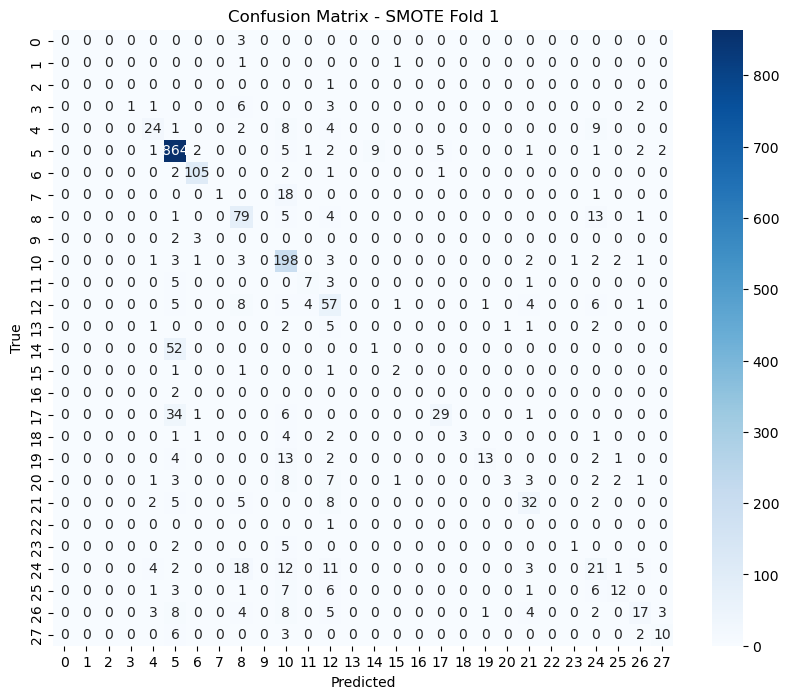

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,3.00
1,0.000000,0.000000,0.000000,2.00
2,0.000000,0.000000,0.000000,1.00
3,1.000000,0.076923,0.142857,13.00
4,0.615385,0.500000,0.551724,48.00
5,0.858847,0.965363,0.908995,895.00
6,0.929204,0.945946,0.937500,111.00
7,1.000000,0.050000,0.095238,20.00
8,0.603053,0.766990,0.675214,103.00
9,0.000000,0.000000,0.000000,5.00


In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(results["SMOTE"]["matrices"][0], annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SMOTE Fold 1")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

pd.DataFrame(results["SMOTE"]["reports"][0]).T  # transpose for readability


In [ ]:
results["SMOTE"]["macro_f1"]

[0.343722469238722,
 0.31017682365215377,
 0.35092955867521736,
 0.322239391735134,
 0.3329656392261139]

In [17]:
summary_df = pd.DataFrame({
    strat: {
        "Avg Macro F1": np.mean(vals["macro_f1"]),
        "Avg Weighted F1": np.mean(vals["weighted_f1"])
    }
    for strat, vals in results.items()
}).T

summary_df.sort_values("Avg Macro F1", ascending=False)


,Avg Macro F1,Avg Weighted F1
SMOTEENN,0.349279,0.685255
SMOTE,0.332007,0.697611
ADASYN,0.313812,0.680448
BorderlineSMOTE,0.312168,0.684762
NoResample,0.241524,0.620271


Evaluating Sequences: 100%|██████████| 5/5 [47:03<00:00, 564.74s/it]


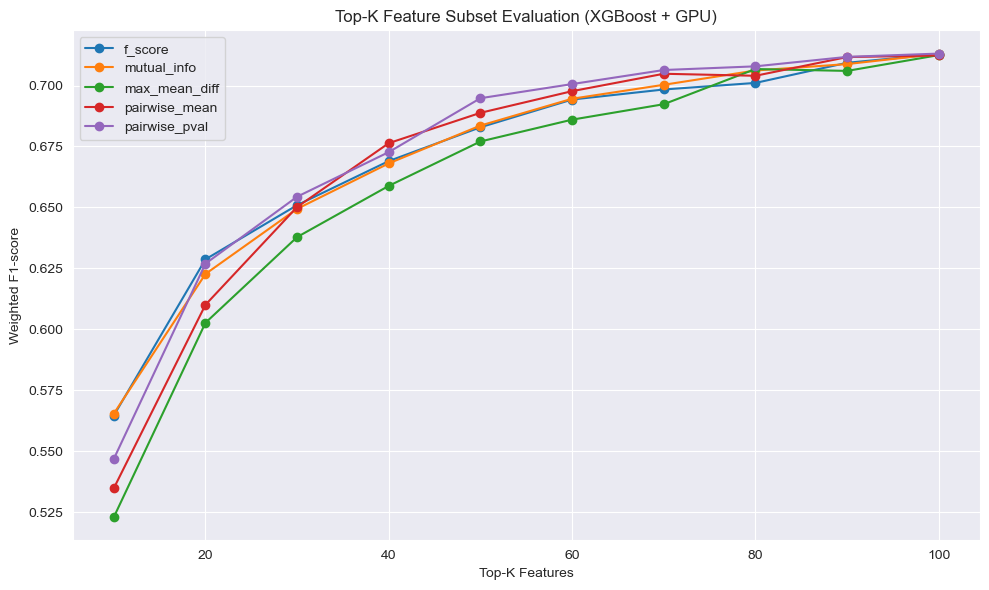


Best Top-K per feature sequence:
f_score              -> Top-100, Weighted F1 = 0.7129
mutual_info          -> Top-100, Weighted F1 = 0.7130
max_mean_diff        -> Top-100, Weighted F1 = 0.7125
pairwise_mean        -> Top-100, Weighted F1 = 0.7123
pairwise_pval        -> Top-100, Weighted F1 = 0.7131


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# === Step 1: 加载数据 ===
X = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()

# 标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === Step 2: 加载特征序列 ===
def load_feature_indices(filepath, column="feature_idx"):
    return pd.read_csv(filepath)[column].astype(int).tolist()

feature_rankings = {
    "f_score": load_feature_indices("../output/f_score_with_p_value.csv"),
    "mutual_info": load_feature_indices("../output/mutual_info_global.csv"),
    "max_mean_diff": load_feature_indices("../output/max_class_mean_diff.csv"),
    "pairwise_mean": load_feature_indices("../output/pairwise_mean_diff_top_10_features.csv"),
    "pairwise_pval": load_feature_indices("../output/pairwise_p_value_top_10_features.csv")
}

# === Step 3: 手动实现 CV + XGBoost GPU 训练 ===
def evaluate_topk_f1_gpu_manualcv(X, y, feature_rankings, k_list=None, cv=5):
    if k_list is None:
        k_list = list(range(10, 101, 10))

    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, ranking in tqdm(feature_rankings.items(), desc="Evaluating Sequences"):
        scores = []

        for k in tqdm(k_list, desc=f"{name} Top-K", leave=False):
            selected_features = ranking[:k]
            X_k = X[:, selected_features]
            f1_scores = []

            for train_idx, val_idx in skf.split(X_k, y):
                X_train_cv, X_val_cv = X_k[train_idx], X_k[val_idx]
                y_train_cv, y_val_cv = y[train_idx], y[val_idx]

                model = XGBClassifier(
                    objective="multi:softprob",
                    num_class=28,
                    eval_metric="mlogloss",
                    use_label_encoder=False,
                    random_state=42,
                    tree_method="gpu_hist",
                    predictor="gpu_predictor",
                    verbosity=0
                )

                model.fit(X_train_cv, y_train_cv)
                y_pred = model.predict(X_val_cv)
                f1 = f1_score(y_val_cv, y_pred, average="weighted", zero_division=0)
                f1_scores.append(f1)

            scores.append((k, np.mean(f1_scores)))
        results[name] = scores
    return results

# === Step 4: 绘图函数 ===
def plot_topk_f1_curves(results):
    plt.figure(figsize=(10, 6))
    for name, score_list in results.items():
        k_vals, f1_vals = zip(*score_list)
        plt.plot(k_vals, f1_vals, marker='o', label=name)

    plt.xlabel("Top-K Features")
    plt.ylabel("Weighted F1-score")
    plt.title("Top-K Feature Subset Evaluation (XGBoost + GPU)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 5: 执行评估并绘图 ===
k_values = list(range(10, 101, 10))
results = evaluate_topk_f1_gpu_manualcv(X, y, feature_rankings, k_list=k_values)
plot_topk_f1_curves(results)

# === Step 6: 输出每组排序的最佳 top-k 与 F1-score ===
best = {name: max(score_list, key=lambda x: x[1]) for name, score_list in results.items()}
print("\nBest Top-K per feature sequence:")
for name, (k, score) in best.items():
    print(f"{name:20s} -> Top-{k:3d}, Weighted F1 = {score:.4f}")

Evaluating Sequences: 100%|██████████| 5/5 [10:42<00:00, 128.52s/it]


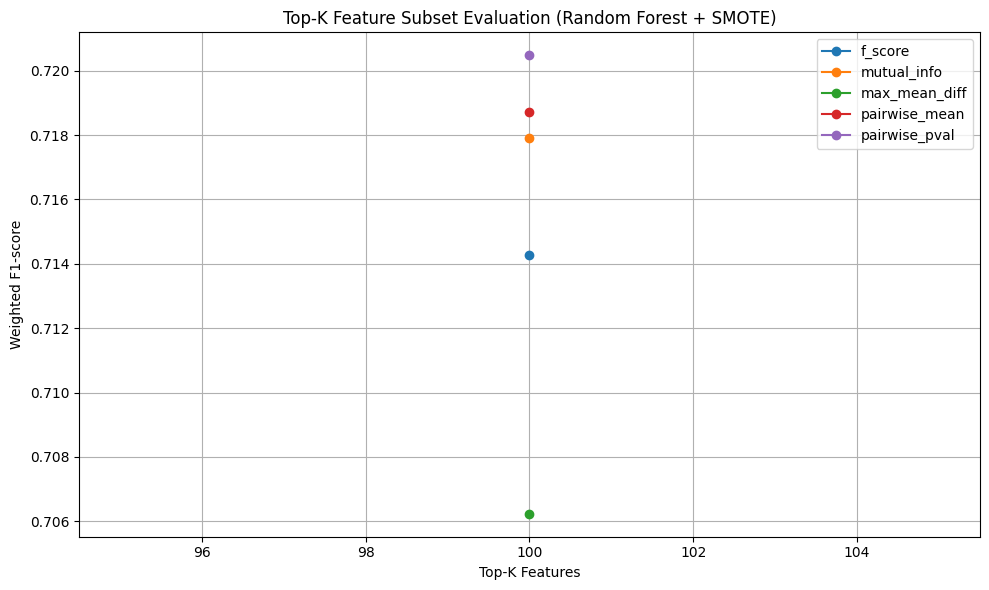


Best Top-K per feature sequence:
f_score              -> Top-100, Weighted F1 = 0.7143
mutual_info          -> Top-100, Weighted F1 = 0.7179
max_mean_diff        -> Top-100, Weighted F1 = 0.7062
pairwise_mean        -> Top-100, Weighted F1 = 0.7187
pairwise_pval        -> Top-100, Weighted F1 = 0.7205

[INFO] Overlap Matrix Among Top-100 Features


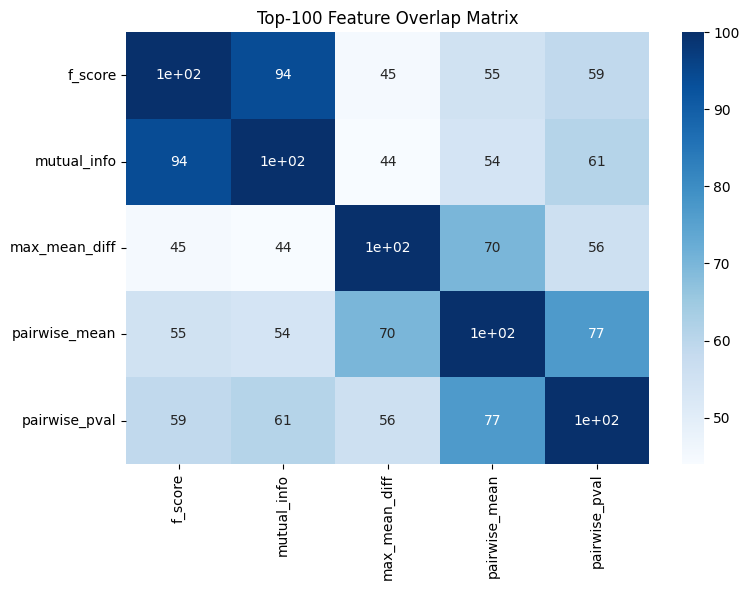

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === Step 1: Load data ===
X = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()

scaler = StandardScaler()
X = scaler.fit_transform(X)

# === Step 2: Load feature rankings ===
def load_feature_indices(filepath, column="feature_idx"):
    df = pd.read_csv(filepath)
    if column in df.columns:
        return df[column].astype(int).tolist()
    else:
        return df.iloc[:, 0].astype(int).tolist()

feature_rankings = {
    "f_score": load_feature_indices("../output/f_score_with_p_value.csv"),
    "mutual_info": load_feature_indices("../output/mutual_info_global.csv"),
    "max_mean_diff": load_feature_indices("../output/max_class_mean_diff.csv"),
    "pairwise_mean": load_feature_indices("../output/pairwise_mean_diff_top_10_features.csv"),
    "pairwise_pval": load_feature_indices("../output/pairwise_p_value_top_10_features.csv")
}

# === Step 3: Manual CV + RF + SMOTE ===
def evaluate_topk_f1_rf_manualcv(X, y, feature_rankings, k_list=None, cv=5):
    if k_list is None:
        k_list = [100]

    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, ranking in tqdm(feature_rankings.items(), desc="Evaluating Sequences"):
        scores = []

        for k in tqdm(k_list, desc=f"{name} Top-K", leave=False):
            selected_features = ranking[:k]
            X_k = X[:, selected_features]
            f1_scores = []

            for train_idx, val_idx in skf.split(X_k, y):
                X_train_cv, X_val_cv = X_k[train_idx], X_k[val_idx]
                y_train_cv, y_val_cv = y[train_idx], y[val_idx]

                class_counts = Counter(y_train_cv)
                min_class_count = min(class_counts.values())
                k_safe = max(1, min(5, min_class_count - 1))

                valid_classes = [cls for cls, cnt in class_counts.items() if cnt >= k_safe + 1]
                mask = np.isin(y_train_cv, valid_classes)
                X_train_safe, y_train_safe = X_train_cv[mask], y_train_cv[mask]

                try:
                    sampler = SMOTE(random_state=42, k_neighbors=k_safe)
                    X_resampled, y_resampled = sampler.fit_resample(X_train_safe, y_train_safe)
                except ValueError:
                    X_resampled, y_resampled = X_train_safe, y_train_safe

                model = RandomForestClassifier(
                    n_estimators=200,
                    class_weight="balanced",
                    n_jobs=-1,
                    random_state=42
                )
                model.fit(X_resampled, y_resampled)
                y_pred = model.predict(X_val_cv)
                f1 = f1_score(y_val_cv, y_pred, average="weighted", zero_division=0)
                f1_scores.append(f1)

            scores.append((k, np.mean(f1_scores)))
        results[name] = scores
    return results

# === Step 4: Plot curves ===
def plot_topk_f1_curves(results):
    plt.figure(figsize=(10, 6))
    for name, score_list in results.items():
        k_vals, f1_vals = zip(*score_list)
        plt.plot(k_vals, f1_vals, marker='o', label=name)

    plt.xlabel("Top-K Features")
    plt.ylabel("Weighted F1-score")
    plt.title("Top-K Feature Subset Evaluation (Random Forest + SMOTE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 5: Run evaluation ===
k_values = [100]
results = evaluate_topk_f1_rf_manualcv(X, y, feature_rankings, k_list=k_values)
plot_topk_f1_curves(results)

# === Step 6: Report best top-k ===
best = {name: max(score_list, key=lambda x: x[1]) for name, score_list in results.items()}
print("\nBest Top-K per feature sequence:")
for name, (k, score) in best.items():
    print(f"{name:20s} -> Top-{k:3d}, Weighted F1 = {score:.4f}")

# === Step 7: Overlap matrix ===
print("\n[INFO] Overlap Matrix Among Top-100 Features")
rank_names = list(feature_rankings.keys())
overlap_matrix = np.zeros((len(rank_names), len(rank_names)), dtype=int)

for i, a in enumerate(rank_names):
    for j, b in enumerate(rank_names):
        overlap_matrix[i, j] = len(set(feature_rankings[a][:100]) & set(feature_rankings[b][:100]))

plt.figure(figsize=(8, 6))
sns.heatmap(overlap_matrix, annot=True, xticklabels=rank_names, yticklabels=rank_names, cmap="Blues")
plt.title("Top-100 Feature Overlap Matrix")
plt.tight_layout()
plt.show()
